# Multi-Resolution Dataset Validation

This notebook validates the multi-resolution training pipeline:
1. ImageProcessor with multi-resolution configuration
2. ImageDataset loading and preprocessing
3. Collate function behavior
4. DataLoader functionality

Based on config: `tests/test_configs/test_example_fluxkontext_multiresolution.yaml`


In [1]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import logging

# Configure logging
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)

# Add project root to path
project_root = Path.cwd()
project_root = project_root.parent.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"Project root: {project_root}")
print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


Project root: /mnt/nas/public2/lilong/repos/qwen-image-finetune
Python version: 3.12.11 | packaged by conda-forge | (main, Jun  4 2025, 14:45:31) [GCC 13.3.0]
PyTorch version: 2.5.1+cu121
CUDA available: True


## 1. Load Configuration


In [ ]:
from qflux.data.config import load_config_from_yaml

# Load config
config_path = "../../tests/test_configs/test_example_fluxkontext_multiresolution.yaml"
config = load_config_from_yaml(config_path)

print("\n=== Configuration Loaded ===")
print(f"Config file: {config_path}")
print(f"\nData config:")
print(f"  Dataset: {config.data.init_args.dataset_path}")
print(f"  Batch size: {config.data.batch_size}")
print(f"  Num workers: {config.data.num_workers}")
print(f"\nProcessor config:")
processor_config = config.data.init_args.processor.init_args
print(f"  Process type: {processor_config.process_type}")
print(f"  Resize mode: {processor_config.resize_mode}")
print(f"  Multi-resolutions: {processor_config.multi_resolutions}")
print(f"  Max aspect ratio: {processor_config.max_aspect_ratio}")



=== Configuration Loaded ===
Config file: ../../tests/test_configs/test_example_fluxkontext_multiresolution.yaml

Data config:
  Dataset: [{'split': 'train', 'repo_id': 'TsienDragon/figaro_hair_segmentation_1k'}]
  Batch size: 2
  Num workers: 2

Processor config:
  Process type: center_crop
  Resize mode: bilinear
  Multi-resolutions: [102400, 262144, 409600]
  Max aspect ratio: 3.0


## 2. Test ImageProcessor

Test the processor with various image sizes to verify multi-resolution selection logic.


In [4]:
from src.data.preprocess import ImageProcessor
from PIL import Image

# Initialize processor
processor = ImageProcessor(processor_config)

print("\n=== ImageProcessor Initialized ===")
print(f"Multi-resolutions (pixels): {processor.multi_resolutions}")
print(f"Max aspect ratio: {processor.max_aspect_ratio}")

# Test with various image sizes
test_sizes = [
    (400, 400),   # Close to 512*512
    (600, 600),   # Close to 640*640
    (800, 400),   # Close to 768*512
    (900, 500),   # Close to 832*576
    (1024, 768),  # Larger image
    (300, 900),   # High aspect ratio
]

print("\n=== Testing Multi-Resolution Selection ===")
for orig_w, orig_h in test_sizes:
    # Create dummy image
    dummy_image = np.random.randint(0, 255, (orig_h, orig_w, 3), dtype=np.uint8)

    # Select best resolution
    best_pixels = processor._select_pixels_candidate(orig_w, orig_h)

    # Get target dimensions
    from src.data.preprocess import best_hw_given_area
    new_w, new_h = best_hw_given_area(best_pixels, orig_w, orig_h, step=16)

    orig_ratio = orig_w / orig_h
    new_ratio = new_w / new_h

    print(f"\nOriginal: {orig_w}x{orig_h} ({orig_w*orig_h:,} pixels, ratio={orig_ratio:.2f})")
    print(f"  → Selected: {new_w}x{new_h} ({new_w*new_h:,} pixels, ratio={new_ratio:.2f})")
    print(f"  → Candidate pixels: {best_pixels:,}")
    print(f"  → Area change: {(new_w*new_h - orig_w*orig_h) / (orig_w*orig_h) * 100:+.1f}%")


10/15/2025 15:45:11 - INFO - root - Multi-resolution mode: simple (shared candidates: [102400, 262144, 409600])
10/15/2025 15:45:11 - INFO - root - ImageProcessor initialized with target_size: Nonecontrols_size: Nonetarget_pixels: Nonecontrols_pixels: None



=== ImageProcessor Initialized ===
Multi-resolutions (pixels): [102400, 262144, 409600]
Max aspect ratio: 3.0

=== Testing Multi-Resolution Selection ===

Original: 400x400 (160,000 pixels, ratio=1.00)
  → Selected: 320x320 (102,400 pixels, ratio=1.00)
  → Candidate pixels: 102,400
  → Area change: -36.0%

Original: 600x600 (360,000 pixels, ratio=1.00)
  → Selected: 640x640 (409,600 pixels, ratio=1.00)
  → Candidate pixels: 409,600
  → Area change: +13.8%

Original: 800x400 (320,000 pixels, ratio=2.00)
  → Selected: 1024x256 (262,144 pixels, ratio=4.00)
  → Candidate pixels: 262,144
  → Area change: -18.1%

Original: 900x500 (450,000 pixels, ratio=1.80)
  → Selected: 800x512 (409,600 pixels, ratio=1.56)
  → Candidate pixels: 409,600
  → Area change: -9.0%

Original: 1024x768 (786,432 pixels, ratio=1.33)
  → Selected: 800x512 (409,600 pixels, ratio=1.56)
  → Candidate pixels: 409,600
  → Area change: -47.9%

Original: 300x900 (270,000 pixels, ratio=0.33)
  → Selected: 256x1024 (262,144

## 3. Test Dataset Loading

Load the dataset and inspect individual samples.


In [6]:
from src.data.dataset import ImageDataset
import random

# Create dataset
dataset = ImageDataset(config.data.init_args)
print("\n=== Dataset Loaded ===")
print(f"Total samples: {len(dataset)}")
print(f"Dataset paths: {dataset.dataset_paths}")
print(f"Cache enabled: {dataset.use_cache}")
print(f"Cache exists: {dataset.cache_exists}")

缓存已启用，缓存目录: /tmp/image_edit_lora/figaroHairSegFluxKontextFp4MultiRes/cache


10/15/2025 15:45:52 - INFO - root - Loaded Hugging Face dataset: TsienDragon/figaro_hair_segmentation_1k, {'type': 'huggingface', 'repo_id': 'TsienDragon/figaro_hair_segmentation_1k', 'dataset': Dataset({
    features: ['id', 'control_images', 'control_mask', 'target_image', 'prompt'],
    num_rows: 1000
}), 'length': 1000, 'start_idx': 0}
10/15/2025 15:45:52 - INFO - root - Multi-resolution mode: simple (shared candidates: [102400, 262144, 409600])
10/15/2025 15:45:52 - INFO - root - ImageProcessor initialized with target_size: Nonecontrols_size: Nonetarget_pixels: Nonecontrols_pixels: None



=== Dataset Loaded ===
Total samples: 1000
Dataset paths: [{'split': 'train', 'repo_id': 'TsienDragon/figaro_hair_segmentation_1k'}]
Cache enabled: True
Cache exists: True


In [34]:


# Load first few samples
print("\n=== Sample Inspection ===")
num_samples_to_check = min(3, len(dataset))

for idx in range(num_samples_to_check):
    idx = random.randint(0, len(dataset) - 1)
    sample = dataset[idx]
    print(f"\n--- Sample {idx} ---")
    print(f"Keys: {list(sample.keys())}")

    if 'image' in sample:
        img_shape = sample['image'].shape
        print(f"Image shape: {img_shape} (C, H, W)")

    if 'control' in sample:
        ctrl_shape = sample['control'].shape
        print(f"Control shape: {ctrl_shape} (C, H, W)")

    if 'mask' in sample:
        mask_shape = sample['mask'].shape
        print(f"Mask shape: {mask_shape}")

    if 'img_shapes' in sample:
        print(f"Image shapes (original): {sample['img_shapes']}")

    if 'prompt' in sample:
        prompt_text = sample['prompt'][:100] if isinstance(sample['prompt'], str) else str(sample['prompt'])
        print(f"Prompt: {prompt_text}...")
    if 'image_latents' in sample:
        print(f"Image latents shape: {sample['image_latents'].shape}")
    if 'control_latents' in sample:
        print(f"Control latents shape: {sample['control_latents'].shape}")
    if "pooled_prompt_embeds" in sample:
        print(f"Pooled prompt embeds shape: {sample['pooled_prompt_embeds'].shape}")
    if "prompt_embeds" in sample:
        print(f"Prompt embeds shape: {sample['prompt_embeds'].shape}")
    if 'control_ids' in sample:
        print(f"Control ids shape: {sample['control_ids'].shape}")
    if 'text_ids' in sample:
        print(f"Text ids shape: {sample['text_ids'].shape}")

    print(f"Cached: {sample.get('cached', False)}")
    print(f"N controls: {sample.get('n_controls', 0)}")



=== Sample Inspection ===

--- Sample 334 ---
Keys: ['image', 'control', 'prompt', 'file_hashes', 'cached', 'img_shapes', 'image_latents', 'control_latents', 'pooled_prompt_embeds', 'prompt_embeds', 'control_ids', 'text_ids', 'n_controls']
Image shape: torch.Size([3, 672, 608]) (C, H, W)
Control shape: torch.Size([3, 672, 608]) (C, H, W)
Image shapes (original): [(3, 672, 608), (3, 672, 608)]
Prompt: Produce hair mask for the given image...
Image latents shape: torch.Size([1596, 64])
Control latents shape: torch.Size([1596, 64])
Pooled prompt embeds shape: torch.Size([768])
Prompt embeds shape: torch.Size([512, 4096])
Control ids shape: torch.Size([1596, 3])
Text ids shape: torch.Size([512, 3])
Cached: True
N controls: 0

--- Sample 824 ---
Keys: ['image', 'control', 'prompt', 'file_hashes', 'cached', 'img_shapes', 'image_latents', 'control_latents', 'pooled_prompt_embeds', 'prompt_embeds', 'control_ids', 'text_ids', 'n_controls']
Image shape: torch.Size([3, 640, 416]) (C, H, W)
Contr

torch.Size([1536, 64])

In [8]:
dataset.preprocessor.get_multi_res_cand(multi_res_target=None, input_date="target")


[102400, 262144, 409600]

In [10]:
dataset.preprocessor.get_multi_res_cand(multi_res_target=None, input_date="control_0")


[102400, 262144, 409600]

In [30]:
import numpy as np
img = np.random.randint(0, 255, (1216, 1024, 3), dtype=np.uint8)
out = dataset.preprocessor.preprocess({"image": img}, multi_res_target=[(1216*1024)])





In [31]:
out['image'].shape

torch.Size([3, 1216, 1024])

In [27]:
1088*1088 - 1024*1024, 1216*992- 1024*1024

(135168, 157696)

In [24]:
1216//32*32

1216

In [25]:
992//32*32

992

In [ ]:
preprocess

## 4. Visualize Sample Images

Visualize the processed images to verify resizing works correctly.


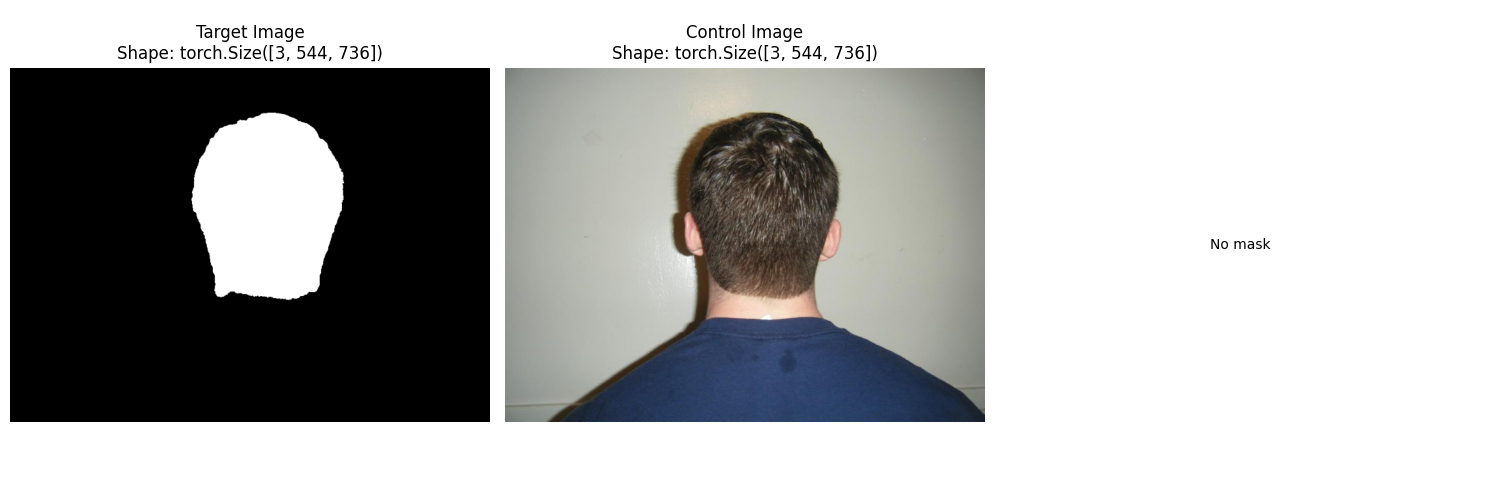


Image shapes in original space: [(3, 544, 736), (3, 544, 736)]


In [35]:
def tensor_to_image(tensor):
    """Convert (C, H, W) tensor in [0, 1] to numpy array for visualization"""
    if isinstance(tensor, torch.Tensor):
        img = tensor.permute(1, 2, 0).cpu().numpy()
    else:
        img = tensor
    img = np.clip(img, 0, 1)
    return img

# Visualize first sample
if len(dataset) > 0:
    sample = dataset[10]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Image
    if 'image' in sample:
        img = tensor_to_image(sample['image'])
        axes[0].imshow(img)
        axes[0].set_title(f"Target Image\nShape: {sample['image'].shape}")
        axes[0].axis('off')

    # Control
    if 'control' in sample:
        ctrl = tensor_to_image(sample['control'])
        axes[1].imshow(ctrl)
        axes[1].set_title(f"Control Image\nShape: {sample['control'].shape}")
        axes[1].axis('off')

    # Mask
    if 'mask' in sample:
        mask = sample['mask'].cpu().numpy() if isinstance(sample['mask'], torch.Tensor) else sample['mask']
        if mask.ndim == 3:
            mask = mask[0]  # Take first channel
        axes[2].imshow(mask, cmap='gray')
        axes[2].set_title(f"Mask\nShape: {sample['mask'].shape}")
        axes[2].axis('off')
    else:
        axes[2].text(0.5, 0.5, 'No mask', ha='center', va='center')
        axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    print(f"\nImage shapes in original space: {sample.get('img_shapes', [])}")


In [36]:
544/32, 736/32

(17.0, 23.0)

## 5. Test Collate Function

Test the collate function with samples of different resolutions.


In [37]:
from src.data.dataset import collate_fn


In [38]:
import torch
latents = [
    torch.randn(2, 4),
    torch.randn(4, 4),
]
batch = ({
    'image': [torch.randn(3, 8, 8), torch.randn(3, 4, 4)],
    'latents': latents,
    'img_shapes':[[(3, 512, 512), (3, 512, 512), (3, 640, 640)],[(3, 128, 512), (3, 128, 512), (3, 128, 640)]],
    'prompt': ['test', 'done'],
})
# convert to list of dicts
batch = [ {k: v[i] for k, v in batch.items()} for i in range(2)]

In [8]:
batch

[{'image': tensor([[[ 0.0878,  1.8684, -0.0242, -0.1774, -0.8029, -0.4012,  0.6046,
             2.2411],
           [-2.1759,  3.2020, -0.1953,  0.1642,  1.0404,  0.0072,  0.4469,
             0.7397],
           [-0.6992, -0.4682,  0.2376, -0.0409, -1.0277, -0.2674, -0.9139,
            -0.6582],
           [ 1.2378, -1.1317,  0.0604, -1.8676,  1.7231, -0.7933,  0.0909,
             0.1177],
           [-0.3544,  1.3960, -0.3927,  0.4390,  1.4411, -1.1719,  0.0704,
            -0.7786],
           [-0.1203,  0.7916, -0.3605, -0.9052,  1.3638,  0.6305, -2.0148,
             1.7062],
           [ 0.8118, -0.3004, -0.1282, -0.0958, -0.2507,  0.4557,  0.2287,
             0.4163],
           [ 1.9176, -0.7487,  1.9992, -0.0851,  0.6526,  0.8283,  0.7930,
             1.0591]],
  
          [[ 0.5253, -1.0141,  1.2158, -0.3631, -0.2602, -0.3503,  1.7203,
             0.2726],
           [ 0.3931, -0.3632, -0.0044, -0.2616, -1.3952, -1.8699, -0.3397,
            -0.4779],
           [-0.64

In [39]:
ollated_batch = collate_fn(batch)

In [40]:
for k, v in ollated_batch.items():
    if isinstance(v, torch.Tensor):
        print(k, v.shape)
    elif isinstance(v, list):
        print(k, len(v))
    else:
        print(k, type(v))

image torch.Size([2, 3, 8, 8])
latents torch.Size([2, 4, 4])
img_shapes 2
prompt 2


In [41]:
ollated_batch['latents']

tensor([[[ 0.2647, -0.2604,  1.8867, -0.0340],
         [ 0.6734, -0.4886, -1.2122, -2.3537],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[-1.0178,  1.3937,  0.4288,  0.0721],
         [-2.1527, -0.0123,  0.6337, -2.0621],
         [-0.7393,  0.8130,  0.6638, -0.2052],
         [-1.1931,  2.5213, -1.3286,  0.1749]]])

In [42]:
latents

[tensor([[ 0.2647, -0.2604,  1.8867, -0.0340],
         [ 0.6734, -0.4886, -1.2122, -2.3537]]),
 tensor([[-1.0178,  1.3937,  0.4288,  0.0721],
         [-2.1527, -0.0123,  0.6337, -2.0621],
         [-0.7393,  0.8130,  0.6638, -0.2052],
         [-1.1931,  2.5213, -1.3286,  0.1749]])]

In [43]:
ollated_batch['img_shapes']

[[(3, 512, 512), (3, 512, 512), (3, 640, 640)],
 [(3, 128, 512), (3, 128, 512), (3, 128, 640)]]

In [44]:

# Create a small batch manually
batch_size = 2
if len(dataset) >= batch_size:
    batch = [dataset[i] for i in range(batch_size)]

    print("\n=== Before Collation ===")
    for i, sample in enumerate(batch):
        print(f"\nSample {i}:")
        if 'image' in sample:
            print(f"  Image shape: {sample['image'].shape}")
        if 'control' in sample:
            print(f"  Control shape: {sample['control'].shape}")
        if 'img_shapes' in sample:
            print(f"  Img shapes: {sample['img_shapes']}")

    # Apply collate function
    collated_batch = collate_fn(batch)

    print("\n=== After Collation ===")
    print(f"Batch keys: {list(collated_batch.keys())}")

    for key, value in collated_batch.items():
        if isinstance(value, torch.Tensor):
            print(f"  {key}: shape={value.shape}, dtype={value.dtype}")
        elif isinstance(value, list):
            print(f"  {key}: list of length {len(value)}")
            if len(value) > 0:
                print(f"    First item type: {type(value[0])}")
        else:
            print(f"  {key}: {type(value)}")

    # Check img_shapes structure
    if 'img_shapes' in collated_batch:
        print(f"\n  img_shapes detail:")
        for i, shapes in enumerate(collated_batch['img_shapes']):
            print(f"    Batch item {i}: {shapes}")



=== Before Collation ===

Sample 0:
  Image shape: torch.Size([3, 640, 640])
  Control shape: torch.Size([3, 640, 640])
  Img shapes: [(3, 640, 640), (3, 640, 640)]

Sample 1:
  Image shape: torch.Size([3, 576, 448])
  Control shape: torch.Size([3, 576, 448])
  Img shapes: [(3, 576, 448), (3, 576, 448)]

=== After Collation ===
Batch keys: ['image', 'control', 'prompt', 'file_hashes', 'cached', 'img_shapes', 'image_latents', 'control_latents', 'pooled_prompt_embeds', 'prompt_embeds', 'control_ids', 'text_ids', 'n_controls']
  image: shape=torch.Size([2, 3, 640, 640]), dtype=torch.float32
  control: shape=torch.Size([2, 3, 640, 640]), dtype=torch.float32
  prompt: list of length 2
    First item type: <class 'str'>
  file_hashes: <class 'dict'>
  cached: list of length 2
    First item type: <class 'bool'>
  img_shapes: list of length 2
    First item type: <class 'list'>
  image_latents: shape=torch.Size([2, 1600, 64]), dtype=torch.float16
  control_latents: shape=torch.Size([2, 1600,

## 6. Test DataLoader

Test the full DataLoader with multiple workers and batching.


In [45]:
from torch.utils.data import DataLoader

# Create dataloader
dataloader = DataLoader(
    dataset,
    batch_size=config.data.batch_size,
    shuffle=config.data.shuffle,
    num_workers=min(config.data.num_workers, 0),  # Use 0 for notebook to avoid multiprocessing issues
    collate_fn=collate_fn,
    drop_last=False,
)

print("\n=== DataLoader Created ===")
print(f"Batch size: {config.data.batch_size}")
print(f"Num workers: 0 (notebook mode)")
print(f"Shuffle: {config.data.shuffle}")
print(f"Total batches: {len(dataloader)}")

# Iterate through a few batches
print("\n=== Testing DataLoader Iteration ===")
num_batches_to_test = min(3, len(dataloader))

for batch_idx, batch in enumerate(dataloader):
    if batch_idx >= num_batches_to_test:
        break

    print(f"\n--- Batch {batch_idx} ---")
    print(f"Keys: {list(batch.keys())}")

    for key, value in batch.items():
        if isinstance(value, torch.Tensor):
            print(f"  {key}: {value.shape} ({value.dtype})")
        elif isinstance(value, list):
            print(f"  {key}: list[{len(value)}]")
            if len(value) > 0 and hasattr(value[0], 'shape'):
                print(f"    → items: {[v.shape if hasattr(v, 'shape') else type(v) for v in value]}")
        else:
            print(f"  {key}: {type(value)}")

    # Verify img_shapes
    if 'img_shapes' in batch:
        print(f"\n  Image shapes per batch item:")
        for i, shapes in enumerate(batch['img_shapes']):
            print(f"    Item {i}: {shapes}")

print("\n=== DataLoader Test Complete ===")



=== DataLoader Created ===
Batch size: 2
Num workers: 0 (notebook mode)
Shuffle: True
Total batches: 500

=== Testing DataLoader Iteration ===

--- Batch 0 ---
Keys: ['image', 'control', 'prompt', 'file_hashes', 'cached', 'img_shapes', 'image_latents', 'control_latents', 'pooled_prompt_embeds', 'prompt_embeds', 'control_ids', 'text_ids', 'n_controls']
  image: torch.Size([2, 3, 864, 576]) (torch.float32)
  control: torch.Size([2, 3, 864, 576]) (torch.float32)
  prompt: list[2]
  file_hashes: <class 'dict'>
  cached: list[2]
  img_shapes: list[2]
  image_latents: torch.Size([2, 1620, 64]) (torch.float16)
  control_latents: torch.Size([2, 1620, 64]) (torch.float16)
  pooled_prompt_embeds: torch.Size([2, 768]) (torch.float16)
  prompt_embeds: torch.Size([2, 512, 4096]) (torch.float16)
  control_ids: torch.Size([2, 1620, 3]) (torch.float16)
  text_ids: torch.Size([2, 512, 3]) (torch.float16)
  n_controls: list[2]

  Image shapes per batch item:
    Item 0: [(3, 704, 576), (3, 704, 576)]
 

## 7. Multi-Resolution Statistics

Analyze the distribution of resolutions in the dataset.


In [46]:
from collections import Counter

# Collect resolution statistics
resolution_counter = Counter()
aspect_ratios = []

num_samples_to_analyze = min(20, len(dataset))

print("\n=== Analyzing Resolution Distribution ===")
print(f"Analyzing {num_samples_to_analyze} samples...\n")

for idx in range(num_samples_to_analyze):
    sample = dataset[idx]

    if 'image' in sample:
        _, h, w = sample['image'].shape
        resolution = (w, h)
        resolution_counter[resolution] += 1
        aspect_ratios.append(w / h)

print("Resolution distribution:")
for resolution, count in resolution_counter.most_common():
    w, h = resolution
    pixels = w * h
    ratio = w / h
    percentage = count / num_samples_to_analyze * 100
    print(f"  {w}x{h} ({pixels:,} pixels, ratio={ratio:.2f}): {count} samples ({percentage:.1f}%)")

if aspect_ratios:
    print(f"\nAspect ratio statistics:")
    print(f"  Min: {min(aspect_ratios):.2f}")
    print(f"  Max: {max(aspect_ratios):.2f}")
    print(f"  Mean: {np.mean(aspect_ratios):.2f}")
    print(f"  Std: {np.std(aspect_ratios):.2f}")



=== Analyzing Resolution Distribution ===
Analyzing 20 samples...

Resolution distribution:
  640x640 (409,600 pixels, ratio=1.00): 2 samples (10.0%)
  288x384 (110,592 pixels, ratio=0.75): 2 samples (10.0%)
  736x544 (400,384 pixels, ratio=1.35): 2 samples (10.0%)
  512x768 (393,216 pixels, ratio=0.67): 2 samples (10.0%)
  512x800 (409,600 pixels, ratio=0.64): 2 samples (10.0%)
  448x576 (258,048 pixels, ratio=0.78): 1 samples (5.0%)
  320x320 (102,400 pixels, ratio=1.00): 1 samples (5.0%)
  480x544 (261,120 pixels, ratio=0.88): 1 samples (5.0%)
  416x640 (266,240 pixels, ratio=0.65): 1 samples (5.0%)
  480x832 (399,360 pixels, ratio=0.58): 1 samples (5.0%)
  768x512 (393,216 pixels, ratio=1.50): 1 samples (5.0%)
  320x800 (256,000 pixels, ratio=0.40): 1 samples (5.0%)
  576x448 (258,048 pixels, ratio=1.29): 1 samples (5.0%)
  544x736 (400,384 pixels, ratio=0.74): 1 samples (5.0%)
  704x576 (405,504 pixels, ratio=1.22): 1 samples (5.0%)

Aspect ratio statistics:
  Min: 0.40
  Max: 1.